In [24]:
pip install tensorflow

In [25]:
import os, pathlib, shutil, random
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [26]:
# Download and extract IMDB dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.7M      0  0:00:04  0:00:04 --:--:-- 16.7M


In [27]:
import os

def review_summary(data_dir="aclImdb", sample_count=5):
    for dataset_type in ["train", "test"]:
        print(f"\nSummary of '{dataset_type}' split:")
        for category in ["pos", "neg"]:
            print(f"  Sentiment: {category}")
            path_to_folder = os.path.join(data_dir, dataset_type, category)
            review_files = os.listdir(path_to_folder)[:sample_count]
            for index, review_file in enumerate(review_files):
                review_path = os.path.join(path_to_folder, review_file)
                with open(review_path, "r", encoding="utf-8") as review:
                    review_text = review.readlines()
                print(f"\n  File {index + 1}: {review_file}")
                print(f"    Lines in file: {len(review_text)}")
                print(f"    First 5 lines (or fewer):")
                print("    " + "\n    ".join(review_text[:5]).strip())


In [28]:
review_summary() # Call the correct function name: review_summary


Summary of 'train' split:
  Sentiment: pos

  File 1: 9592_8.txt
    Lines in file: 1
    First 5 lines (or fewer):
    This film came out 12 years years ago, and was a revelation even for people who knew something of the drag scene in New York. The textbooks on drag performance say nothing of these vogueing houses. Anthony Slide's 'Great Pretenders' says nothing. Julian Fleisher's "The Drag Queens of New York: An Illustrated Field Guide" with its flow chart of influence that pulls together Julian Eltinge, Minette, the Warhol queens, and the 90s club scene - and postdates the film - ignores the houses completely. Even Laurence Senelick's "The Changing Room" - the closest thing that we have to a definitive book on drag performance rushes quickly past the film and does not give the background information that one would have expected from it.<br /><br />I understand from the film itself,and various articles I found on the web that this house system goes back decades. The major film perfo

In [29]:
import os
import shutil
import random
import pathlib

sample_size = 32
root_path = pathlib.Path("aclImdb")
validation_path = root_path / "val"
training_path = root_path / "train"

for label in ("neg", "pos"):
    os.makedirs(validation_path / label, exist_ok=True)
    file_list = os.listdir(training_path / label)
    random.Random(1337).shuffle(file_list)
    split_count = int(0.2 * len(file_list))
    validation_files = file_list[-split_count:]

    for filename in validation_files:
        source = training_path / label / filename
        destination = validation_path / label / filename
        if not os.path.exists(destination):
            shutil.move(source, destination)


In [30]:
from tensorflow import keras

# Load datasets with new variable names
training_data = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=sample_size
)

validation_data = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=sample_size
)

testing_data = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=sample_size
)

text_inputs_only = training_data.map(lambda features, labels: features)


Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**1) Cutoff reviews after 150 words**

In [31]:
# Configure preprocessing parameters
sequence_len = 150
vocab_limit = 10000

vectorizer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=sequence_len,
)

vectorizer.adapt(text_inputs_only)


In [32]:
# Vectorized datasets
tokenized_train = training_data.map(
    lambda text, label: (vectorizer(text), label),
    num_parallel_calls=4).take(100)

tokenized_val = validation_data.map(
    lambda text, label: (vectorizer(text), label),
    num_parallel_calls=4).take(10000)

tokenized_test = testing_data.map(
    lambda text, label: (vectorizer(text), label),
    num_parallel_calls=4)


In [33]:
# Model using an Embedding Layer
input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=vocab_limit, output_dim=128)(input_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(32))(embedding_output)
dropout_layer = layers.Dropout(0.2)(bi_lstm)
final_output = layers.Dense(1, activation="sigmoid")(dropout_layer)

text_classifier = keras.Model(input_layer, final_output)

text_classifier.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

text_classifier.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_callbacks = [
    keras.callbacks.ModelCheckpoint("text_classifier.keras", save_best_only=True)
]


In [35]:
training_history = text_classifier.fit(
    tokenized_train, validation_data=tokenized_val, epochs=10, callbacks=model_callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.5034 - loss: 0.6928 - val_accuracy: 0.5342 - val_loss: 0.6856
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6233 - loss: 0.6487 - val_accuracy: 0.7230 - val_loss: 0.5575
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7435 - loss: 0.5129 - val_accuracy: 0.7980 - val_loss: 0.4553
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8462 - loss: 0.3794 - val_accuracy: 0.7742 - val_loss: 0.4853
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8739 - loss: 0.3100 - val_accuracy: 0.7884 - val_loss: 0.4471
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9122 - loss: 0.2429 - val_accuracy: 0.8076 - val_loss: 0.4558
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9318 - loss: 0.1874 - val_accuracy: 0.7216 - val_loss: 0.7474
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9453 - loss: 0.1553 - val_acc

**2) Restrict training samples to 100 3) Validate on 10,000 samples**

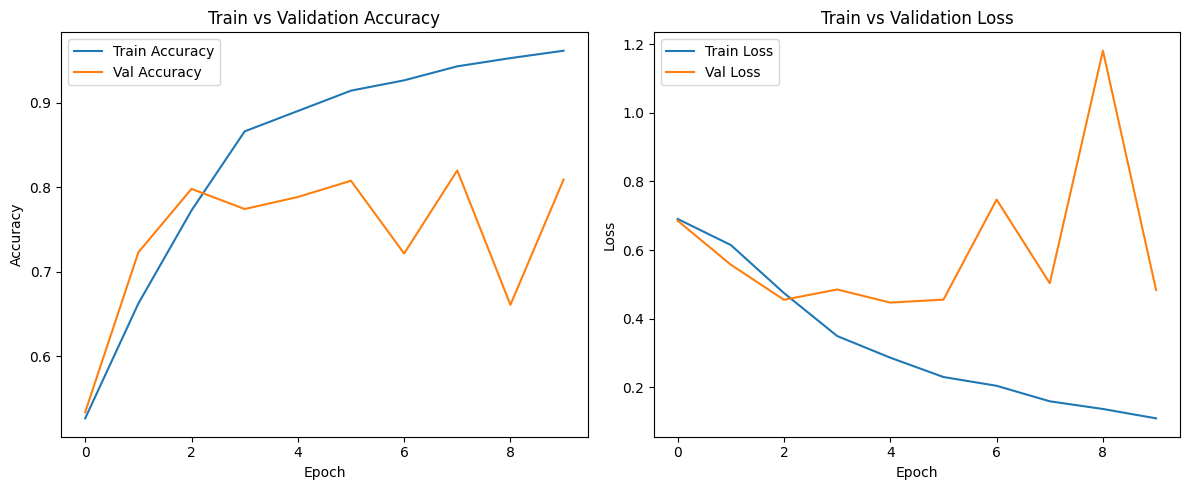

In [36]:
import matplotlib.pyplot as plt

# Extract metrics from training history
metrics_log = training_history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(metrics_log['accuracy'], label='Train Accuracy')
plt.plot(metrics_log['val_accuracy'], label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(metrics_log['loss'], label='Train Loss')
plt.plot(metrics_log['val_loss'], label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [43]:
# Load Pretrained Word Embeddings (GloVe)

# Download GloVe vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-04-15 20:41:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-15 20:41:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-15 20:41:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [45]:
# Build embedding matrix from GloVe
embedding_size = 100
glove_file_path = "glove.6B.100d.txt"

pretrained_vectors = {}
with open(glove_file_path) as file:
    for entry in file:
        token, values = entry.split(maxsplit=1)
        values = np.fromstring(values, "f", sep=" ")
        pretrained_vectors[token] = values

token_list = vectorizer.get_vocabulary()
token_to_index = dict(zip(token_list, range(len(token_list))))

glove_matrix = np.zeros((vocab_limit, embedding_size))
for token, idx in token_to_index.items():
    if idx < vocab_limit:
        vector = pretrained_vectors.get(token)
        if vector is not None:
            glove_matrix[idx] = vector


**5. Before the layers.Bidirectional layer, consider a) an embedding layer, .**

In [46]:
# Model using pretrained GloVe embeddings
frozen_embedding = layers.Embedding(
    vocab_limit,
    embedding_size,
    embeddings_initializer=keras.initializers.Constant(glove_matrix),
    trainable=False,
    mask_zero=True,
)

input_tensor = keras.Input(shape=(None,), dtype="int64")
embedded_input = frozen_embedding(input_tensor)
lstm_output = layers.Bidirectional(layers.LSTM(32))(embedded_input)
dropout_output = layers.Dropout(0.2)(lstm_output)
final_prediction = layers.Dense(1, activation="sigmoid")(dropout_output)
glove_model = keras.Model(input_tensor, final_prediction)


In [40]:
input_seq = keras.Input(shape=(None,), dtype="int64")
embedded_seq = frozen_embedding(input_seq)
rnn_output = layers.Bidirectional(layers.LSTM(32))(embedded_seq)
dropout_layer = layers.Dropout(0.2)(rnn_output)
prediction = layers.Dense(1, activation="sigmoid")(dropout_layer)
glove_based_model = keras.Model(input_seq, prediction)

glove_based_model.compile(optimizer="rmsprop",
                          loss="binary_crossentropy",
                          metrics=["accuracy"])

glove_based_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 100) │  1,000,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     34,048 │ embedding_3[1][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [41]:
glove_callbacks = [
    keras.callbacks.ModelCheckpoint("glove_based_model.keras", save_best_only=True)
]

glove_training_history = glove_based_model.fit(
    tokenized_train, validation_data=tokenized_val, epochs=10, callbacks=glove_callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.5323 - loss: 0.6982 - val_accuracy: 0.6432 - val_loss: 0.6465
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6501 - loss: 0.6330 - val_accuracy: 0.7086 - val_loss: 0.5834
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.7061 - loss: 0.5787 - val_accuracy: 0.7294 - val_loss: 0.5414
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7159 - loss: 0.5569 - val_accuracy: 0.7188 - val_loss: 0.5542
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7305 - loss: 0.5396 - val_accuracy: 0.7512 - val_loss: 0.5205
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7585 - loss: 0.5058 - val_accuracy: 0.7536 - val_loss: 0.5036
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7662 - loss: 0.4855 - val_accuracy: 0.7704 - val_loss: 0.4804
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7886 - loss: 0

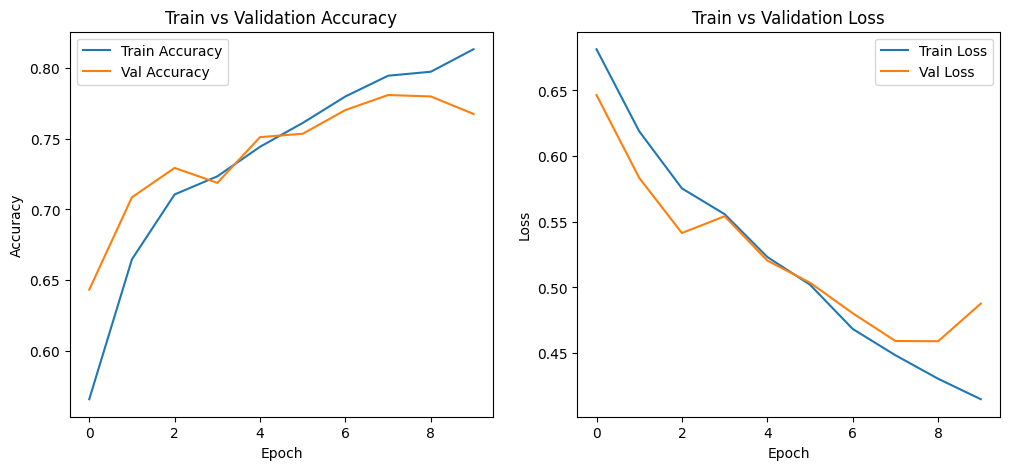

In [42]:
import matplotlib.pyplot as plt

# Extract metrics from training history
glove_metrics = glove_training_history.history

# Create plot figure
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(glove_metrics['accuracy'], label='Train Accuracy')
plt.plot(glove_metrics['val_accuracy'], label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(glove_metrics['loss'], label='Train Loss')
plt.plot(glove_metrics['val_loss'], label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display plots
plt.show()



**b) a pretrained word embedding.**


### Running training with 100 samples ###

Training model with custom embeddings using 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9906 - loss: 0.0420 - val_accuracy: 0.7452 - val_loss: 1.3427
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9773 - loss: 0.0788 - val_accuracy: 0.7930 - val_loss: 0.7012
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9923 - loss: 0.0291 - val_accuracy: 0.7760 - val_loss: 0.6147
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9965 - loss: 0.0258 - val_accuracy: 0.7872 - val_loss: 0.8526
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9913 - loss: 0.0306 - val_accuracy: 0.7956 - val_loss: 0.8215
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9958 - loss: 0.0179 - val_accuracy: 0.7808 - val_loss: 0.7895
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9949 - loss: 0.0213 - val_accuracy: 0.8006 - val_loss: 0.8

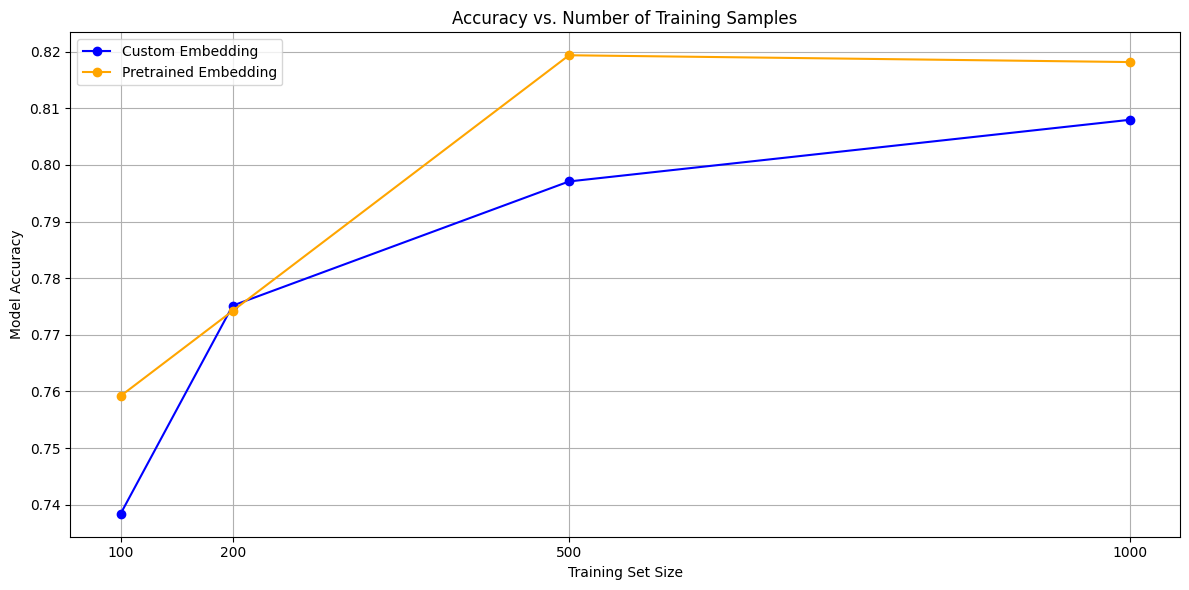

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Sample size settings
sample_sizes = [100, 200, 500, 1000]
custom_acc_results = []
pretrained_acc_results = []

# Initialize plot
plt.figure(figsize=(12, 6))
plt.title('Accuracy vs. Number of Training Samples')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.grid(True)

# Loop over different training sample sizes
for idx, sample_count in enumerate(sample_sizes):
    print(f"\n### Running training with {sample_count} samples ###\n")

    # Prepare subset of training data
    limited_train_data = training_data.map(
        lambda text, label: (vectorizer(text), label)).take(sample_count)

    # Train model with custom embeddings
    print(f"Training model with custom embeddings using {sample_count} samples:")
    text_classifier.fit(
        limited_train_data,
        validation_data=tokenized_val,
        epochs=10,
        verbose=1
    )
    custom_acc = text_classifier.evaluate(tokenized_test, verbose=1)[1]
    custom_acc_results.append(custom_acc)
    print(f"Custom Embedding Accuracy: {custom_acc:.4f}\n")

    # Train model with pretrained embeddings
    print(f"Training model with pretrained embeddings using {sample_count} samples:")
    glove_based_model.fit(
        limited_train_data,
        validation_data=tokenized_val,
        epochs=10,
        verbose=1
    )
    pretrained_acc = glove_based_model.evaluate(tokenized_test, verbose=1)[1]
    pretrained_acc_results.append(pretrained_acc)
    print(f"Pretrained Embedding Accuracy: {pretrained_acc:.4f}\n")

    # Final plot generation after last iteration
    if idx == len(sample_sizes) - 1:
        plt.plot(sample_sizes, custom_acc_results, marker='o', label='Custom Embedding', color='blue')
        plt.plot(sample_sizes, pretrained_acc_results, marker='o', label='Pretrained Embedding', color='orange')

# Final touches to plot
plt.title('Accuracy vs. Number of Training Samples')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.xticks(sample_sizes)
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


**4.) Consider only the top 10,000 words**

In [21]:
import pandas as pd

# Store results for custom embedding model
custom_results = {
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": custom_acc_results,
}

# Store results for pretrained embedding model
pretrained_results = {
    "Sample Size": sample_sizes,
    "Pretrained Embedding Accuracy": pretrained_acc_results,
}

# Combine results into a single DataFrame
results_summary = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": custom_acc_results,
    "Pretrained Embedding Accuracy": pretrained_acc_results
})

# Output the summary table
print("Accuracy Comparison Summary:")
print(results_summary)


Accuracy Comparison Summary:
   Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
0          100                    0.73840                        0.75920
1          200                    0.77516                        0.77424
2          500                    0.79708                        0.81936
3         1000                    0.80796                        0.81816


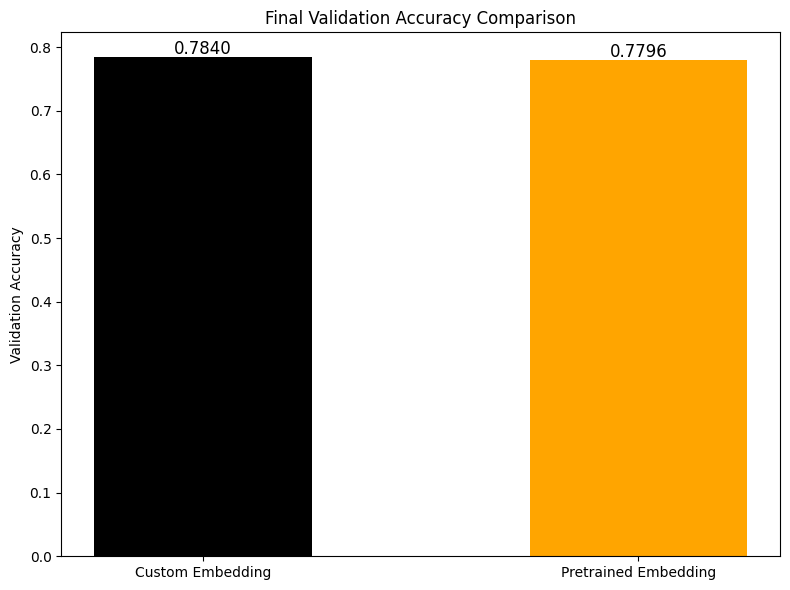

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Model labels and validation accuracies
model_labels = ['Custom Embedding', 'Pretrained Embedding']
final_accuracies = [
    training_history.history['val_accuracy'][-1],     # Last val accuracy from custom model
    glove_training_history.history['val_accuracy'][-1]  # Last val accuracy from pretrained model
]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_labels, final_accuracies, color=['black', 'orange'], width=0.5)

# Add chart labels and title
plt.ylabel('Validation Accuracy')
plt.title('Final Validation Accuracy Comparison')

# Annotate bars with accuracy values
for idx, accuracy in enumerate(final_accuracies):
    plt.text(idx, accuracy + 0.005, f'{accuracy:.4f}', ha='center', fontsize=12)

# Display chart
plt.tight_layout()
plt.show()



**b) a pretrained word embedding.**

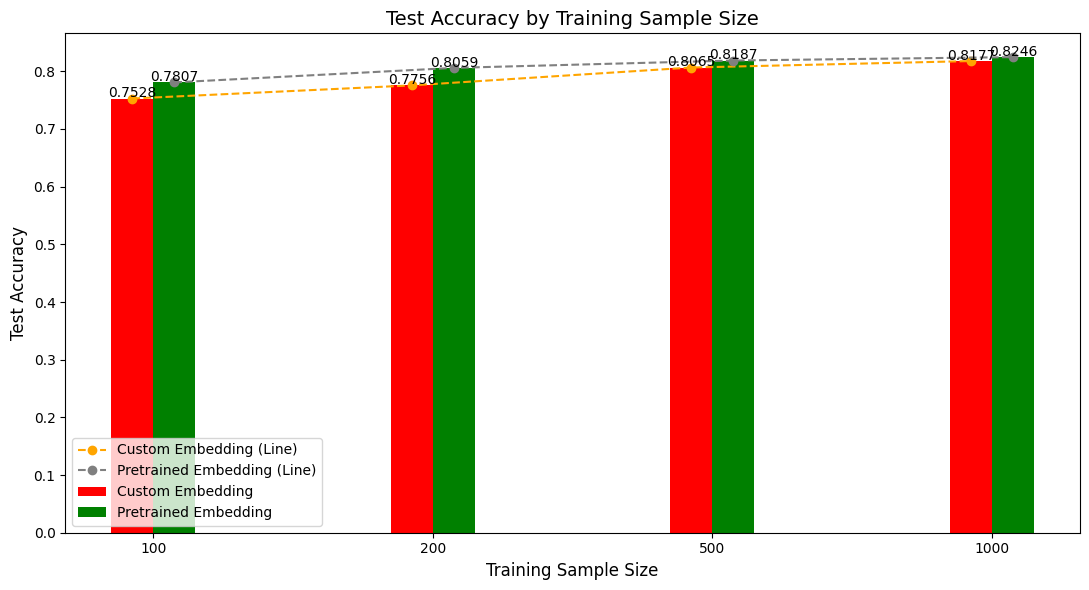

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Input data
sample_counts = [100, 200, 500, 1000]
custom_scores = [0.75280, 0.77556, 0.80652, 0.81772]        # Custom embedding accuracy values
pretrained_scores = [0.78072, 0.80588, 0.81868, 0.82456]    # Pretrained embedding accuracy values

# Bar settings
bar_width = 0.15
x_indices = np.arange(len(sample_counts))  # X-axis positions

# Create figure
plt.figure(figsize=(11, 6))

# Plot bars for both models
plt.bar(x_indices - bar_width / 2, custom_scores,
        width=bar_width, label='Custom Embedding', color='red')
plt.bar(x_indices + bar_width / 2, pretrained_scores,
        width=bar_width, label='Pretrained Embedding', color='green')

# Overlay accuracy trend lines
plt.plot(x_indices - bar_width / 2, custom_scores,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_indices + bar_width / 2, pretrained_scores,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Add chart labels and title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy by Training Sample Size', fontsize=14)
plt.xticks(x_indices, sample_counts)
plt.legend()

# Annotate bars with accuracy values
for j in range(len(sample_counts)):
    plt.text(x_indices[j] - bar_width / 2, custom_scores[j] + 0.002,
             f'{custom_scores[j]:.4f}', ha='center', fontsize=10)
    plt.text(x_indices[j] + bar_width / 2, pretrained_scores[j] + 0.002,
             f'{pretrained_scores[j]:.4f}', ha='center', fontsize=10)

# Final layout
plt.tight_layout()
plt.show()
